# nmi | 2024 spring
## lecture 13 : adaptive quadrature


### 5.4 adapative quadrature

vocabulary: [quadrature@wiki](https://en.wikipedia.org/wiki/Numerical_integration#Connection_with_differential_equations), [squaring the circle](https://en.wikipedia.org/wiki/Squaring_the_circle)

"quadrature" $\equiv$ "calculating area".
</br></br>

**previously**: integration methods that used (two) end points with $f''$ error term then used three points with $f'''$ error term then intervals without one end point (ie, "open"); extrapolated with extra, evenly spaced partitions; combined those ideas.
</br>
**unsurprisingly**: the next step is to do away with "evenly spaced".
</br></br>

bc 1) higher order error may complicate choosing $h$ to meet that error; 1a) if input is data, there is no function for derivatives; and 2) what happens if the function or data behaves differently over given domain?
</br></br>

adaptive quadrature uses error formulas to inform step sizes per interval. eg, in the images below, step size $h$ decreases in magnitude / increases in frequency with increase in rate of change. ie, increasing partitions decreases error.


consider the trapezoid rule which covers area $S$ over interval $[a,b]$ where $h = b-a$ and $a<c_0<b$.
</br></br>

$$\int_a^b f(x)dx = S_{[a,b]} - h^3\frac{f''(c_0)}{12}.$$
</br>

split the interval at midpoint $c$ with $a<c_1<c$, $c<c_2<b$ and $c_1<c_3<c_2$ (gIVT).
</br></br>

\begin{align}
\int_a^b f(x)dx &= S_{[a,c]} - \frac{h^3}{8}\frac{f''(c_1)}{12} + S_{[c,b]}- \frac{h^3}{8}\frac{f''(c_2)}{12} \\ \\
&= S_{[a,c]} + S_{[c,b]} - \frac{h^3}{4}\frac{f''(c_3)}{12}.
\end{align}
</br>

sub out the integrals,
</br></br>

\begin{align}
S_{[a,b]} - (S_{[a,c]} + S_{[c,b]}) &= h^3\frac{f''(c_0)}{12} -\frac{h^3}{4}\frac{f''(c_3)}{12} \\
\\
&\Downarrow \quad f''(c_3) \approx f''(c_0) \\
\\
&\approx \frac{3}{4}h^3\frac{f''(c_3)}{12}.
\end{align}
</br>

algebra and one approximation removed the integrals, :). and error <u>between the two methods</u> is the last approximation previous. ie, two half-intervals improves error by diminishing to the already introduced factor of $\frac{1}{2^n}$; alternatively, that the error of the half-partitions is $\frac{1}{3}$ of the difference of error between the two methods.
</br></br>

explicitly, the idea is to do that as needed over subintervals. ie, maybe one subinterval meets a predetermined maximum error without the extrapolation of further partitions but another needs improvement with them.
</br>

#### algorithm



```
# adaptive quadrature, trapezoid

def f_aquad(af,aa,ab,ah0,aeps):
  c = (aa+ab)/2
  s_ab = (ab-aa)/2*(af(aa) + af(ab))
  s_ac = (c-aa)/2*(af(aa) + af(c))
  s_cb = (ab-c)/2*(af(c) + af(ab))
  if abs(s_ab -(s_ac+s_cb)) < 3*aeps*(ab-aa)/(ah0):
    # accept approximation over [aa,ab]
    pass
  else:
    # recurse
    s_ac = f_aquad(af,aa,c,ah0)
    s_cb = f_aquad(af,c,ab,ah0)
  s_ab = s_ac + s_cb
  return s_ab

s = f_aquad(f,a,b,b-a,TOL)
```



##### example 12


use adaptive quadrature to approximate the integral
</br></br>

$$\int_{-1}^1 (1 + sin \text{ }e^{3x}) \text{ }dx.$$
</br>


###### code


trapezoid: 2.501860 w 140 panels.
 simpsons: 5.000237 w  22 panels.


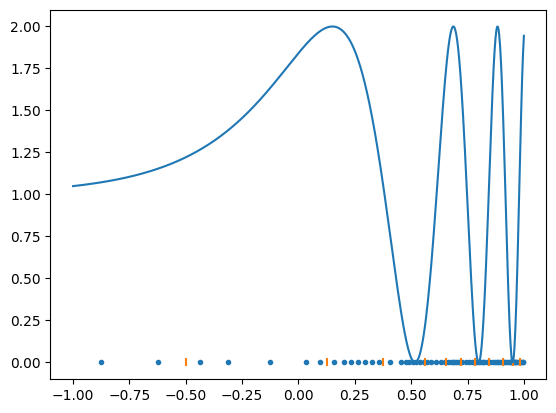

In [1]:
# examples 12, 13

import matplotlib.pyplot as plt
import numpy as np

def adaptive_trapezoid(af,aa,ab,ah0,aeps,all=False):
  """
  af : function to integrate
  aa : subinterval, left bound
  ab : subinterval, right bound
  ah0 : interval length
  aeps : error bound
  all : amount of return data
  returns : approximate integral, number of panels, midpoints of panels
  """
  count = 0
  midpoints = []

  a = aa; b = ab
  c = (a + b)/2
  fa = af(a); fb = af(b); fc = af(c);
  s_ab = (fa + fb)*(b - a)/2
  s_ac = (fa + fc)*(c - a)/2
  s_cb = (fc + fb)*(b - c)/2
  if abs(s_ab -(s_ac+s_cb)) < 3*aeps*(b-a)/(ah0):
    # accept approximation over [aa,ab]
    if all:
      count += 2
      midpoints.append(c)
  else:
    # recurse
    if all:
      s_ac,count_ac,midpoint_ac = adaptive_trapezoid(af,a,c,ah0,aeps,all)
      s_cb,count_cb,midpoint_cb = adaptive_trapezoid(af,c,b,ah0,aeps,all)
      count += count_ac + count_cb
      midpoints = midpoints + midpoint_ac + midpoint_cb
    else:
      s_ac = adaptive_trapezoid(af,a,c,ah0,aeps,all)
      s_cb = adaptive_trapezoid(af,c,b,ah0,aeps,all)

  s_ab = s_ac + s_cb
  if all:
    return s_ab,count,midpoints
  else:
    return s_ab

def adaptive_simpson(af,aa,ab,ah0,aeps,all=False):
  """
  af : function to integrate
  aa : subinterval, left bound
  ab : subinterval, right bound
  ah0 : interval length
  aeps : error bound
  all : amount of return data
  returns : approximate integral, number of panels, midpoints of panels
  """
  count = 0
  midpoints = []

  a = aa; b = ab
  c = (a + b)/2
  fa = af(a); fb = af(b); fc = af(c);
  # 3rd point for simpsons parabolic fit
  m1 = (c + a)/2; m2 = (b + c)/2
  fm1 = af(m1); fm2 = af(m2)

  s_ab = (fa + 4*fc  + fb)*(b - a)/3
  s_ac = (fa + 4*fm1 + fc)*(c - a)/3
  s_cb = (fc + 4*fm2 + fb)*(b - c)/3
  if abs(s_ab -(s_ac+s_cb)) < 15*aeps*(b-a)/(ah0):
    # accept approximation over [aa,ab]
    if all:
      count += 2
      midpoints.append(c)
  else:
    # recurse
    if all:
      s_ac,count_ac,midpoint_ac = adaptive_simpson(af,a,c,ah0,aeps,all)
      s_cb,count_cb,midpoint_cb = adaptive_simpson(af,c,b,ah0,aeps,all)
      count += count_ac + count_cb
      midpoints = midpoints + midpoint_ac + midpoint_cb
    else:
      s_ac = adaptive_simpson(af,a,c,ah0,aeps)
      s_cb = adaptive_simpson(af,c,b,ah0,aeps)

  s_ab = s_ac + s_cb
  if all:
    return s_ab,count,midpoints
  else:
    return s_ab

def main():
  f = lambda x: 1+ np.sin(np.exp(3*x))

  a = -1
  b = 1
  TOL = 0.005

  s_trapezoid,count_trapezoid,midpoints_trapezoid = adaptive_trapezoid(f,a,b,b-a,TOL,all=True)
  print(f"trapezoid: {s_trapezoid:.6f} w {count_trapezoid:3d} panels.")

  s_simpsons,count_simpsons,midpoints_simpsons = adaptive_simpson(f,a,b,b-a,TOL,all=True)
  print(f" simpsons: {s_simpsons:.6f} w {count_simpsons:3d} panels.")

  xs_dis = np.linspace(a,b,1001)
  plt.plot(xs_dis,f(xs_dis))
  plt.scatter(midpoints_trapezoid,[0]*len(midpoints_trapezoid),marker=".")
  plt.scatter(midpoints_simpsons,[0]*len(midpoints_simpsons),marker="|")
  plt.show()

if __name__ == "__main__":
  main()


#### adaptive simpsons

a similar derivation against simpson yields:
</br></br>

\begin{align}
  \int_a^b f(x) \text{ }dx &= S_{[a,b]} - \frac{h^3}{90}f^{(iv)}(c_0) \\
  \\
  \int_a^b f(x) \text{ }dx &= S_{[a,c]} - \frac{(\frac{h}{2})^3}{90}f^{(iv)}(c_1) + S_{[c,b]} - \frac{(\frac{h}{2})^3}{90}f^{(iv)}(c_2)\\
  &= S_{[a,c]} + S_{[c,b]} - \frac{2h^3}{32\cdot 90}f(^{(iv)}(c_3) \\
  \\
  &\Downarrow \\
  \\
  S_{[a,b]} - (S_{[a,c]} + S_{[c,b]}) &= h^5\frac{f^{(iv)}(c_0)}{90} - \frac{h^5}{16}\frac{f^{(iv)}(c_3)}{90} \approx \frac{15}{16}h^3\frac{f^{(iv)}(c_0)}{90}
\end{align}
</br>

where $f^{(iv)}(c_3) \approx f^{(iv)}(c_0)$. ie, "15" replaces "3" as TOL in adpative algorithm above although "10" is more commonly used for a more conservative algorithm.
</br></br>

adaptive simpsons applied to $\int_{-1}^1 (1+sin(e^{3x}))dx$ is the source for sauer, 2nd, figure 5 above.
